In [7]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
#use_python("/home/vsevim/software/anaconda3/envs/R42/bin/python")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [8]:
set.seed(1234)
options(digits=2)
stats <- c()

In [9]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    # data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"

    prj_name = "Screen2_101vecs"
    # data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    save_seurat_h5 = "NO"
}


In [10]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [11]:
updated_integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated.h5seurat")
seurat <- LoadH5Seurat(updated_integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


# How many zero-call cells in each library with this filtering scheme?

In [12]:
select_no_call_cells = seurat$guide_calls == "NA"
cat("total no call cells", sum(select_no_call_cells))
table(seurat@meta.data[select_no_call_cells, ]$library)

total no call cells 24469


Lib_1 Lib_2 Lib_3 Lib_4 Lib_5 Lib_6 Lib_7 Lib_8 Lib_9 
 2462  2716  3002  2745  2506  2699  2489  2802  3048 

# Inspect a library

Select library here

In [13]:
my_library = 'Lib_1'
seurat_subset = subset(seurat, subset = library == my_library)

## Inspect sgRNA counts/cell

In [14]:
df_sums = data.frame(colSums(seurat_subset[['sgRNA']]@counts))
colnames(df_sums) = "sgRNA_count"
nrow(df_sums)

[1] 4475

Warning message:
"Removed 1566 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


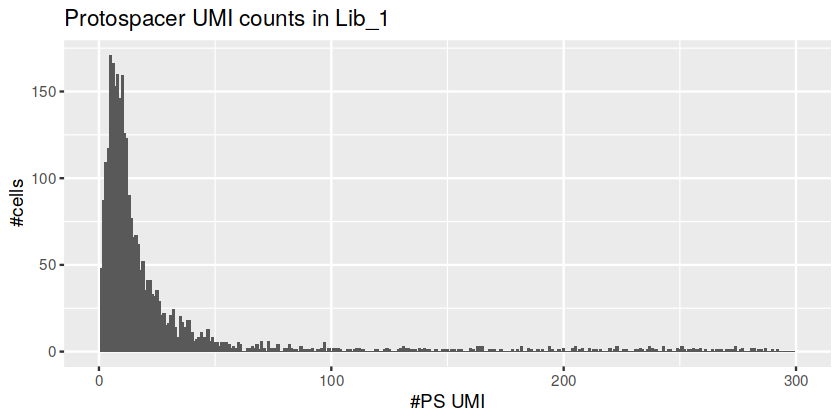

In [15]:
options(repr.plot.width=7, repr.plot.height=3.5)
title = paste("Protospacer UMI counts in", my_library)

ggplot(df_sums, aes(x = sgRNA_count)) +
    geom_histogram(binwidth=1) +
    labs(x = "#PS UMI") +
    labs(y = "#cells") + 
    labs(title = title) +
    xlim(0,300)

### How many cells with a count < 50?

In [16]:
cutoff = 50
n_low_count = sum(df_sums$sgRNA_count < cutoff)
num_cells = nrow(df_sums)
perc_low_count = round(100*n_low_count/num_cells,1)
cat(green(my_library, " ----------- \n"))
cat("#cells in library :")
cat(yellow(num_cells), "\n")
cat("#cells with #sgRNA <", cutoff, ": ")
cat(yellow(n_low_count), "\n")
cat("%cells with #sgRNA <", cutoff, ": ")
cat(yellow(paste0(perc_low_count, "%")), "\n")

Lib_1  ----------- 
#cells in library :4475 
#cells with #sgRNA < 50 : 2629 
%cells with #sgRNA < 50 : 58.7% 


### Identify zero-count guides

In [17]:
rownames(seurat_subset@misc$thresholds) = seurat_subset@misc$thresholds$guide

In [18]:
guide_list = rownames(seurat_subset[['sgRNA']])
df_dummy = seurat_subset@misc$thresholds[guide_list, ]
seurat_subset@misc$thresholds[guide_list, ]


,guide,Lib_1,Lib_2,Lib_3,Lib_4,Lib_5,Lib_6,Lib_7,Lib_8,Lib_9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD13-1a,CD13-1a,4,52,9,8,28,7,3,9,16
CD13-1b,CD13-1b,13,12,3,3,4,5,4,3,5
CD55-1a,CD55-1a,10,81,5,4,7,11,5,3,NA
CD55-1b,CD55-1b,11,75,11,3,4,4,4,4,2
CD73-1a,CD73-1a,18,6,6,5,6,16,6,7,4
CD73-1b,CD73-1b,4,50,9,4,9,27,31,10,3
FUBP1-1a,FUBP1-1a,11,437,18,23,5,219,9,23,NA
FUBP1-1b,FUBP1-1b,11,5,7,4,2,13,8,7,NA
C15orf40-1a,C15orf40-1a,4,5,9,11,20,49,4,7,10


In [19]:
for(guide in guide_list) {
    s = sum(seurat_subset[['sgRNA']]@counts[guide, ] > 0)
    if(s == 0) {
        cat(green(guide), "\t", s, "\n") 
    } else {
        #cat(guide, "\t", s, "\n") 
    }
}


FTH1-2b 	 0 
DE2-1a 	 0 
DE2-1b 	 0 
DE9-2a 	 0 
DE9-2b 	 0 
DE16-2a 	 0 
NTCE1-1b 	 0 
NTCE2-1a 	 0 
NTCE2-1b 	 0 
DE22-2a 	 0 


### Find cells with zero calls

In [20]:
rownames(seurat_subset@misc$thresholds) = seurat_subset@misc$thresholds$guide

In [21]:
guide_list = rownames(seurat_subset[['sgRNA']])
df_dummy = seurat_subset@misc$thresholds[guide_list, ]
#head(seurat_subset@misc$thresholds[guide_list, ])
thresholds_for_lib = seurat_subset@misc$thresholds[guide_list, my_library]
thresholds_for_lib[is.na(thresholds_for_lib)] = 1e50

In [22]:
ps_counts = t(seurat_subset[['sgRNA']]@counts)
select_zero_call_cells = rowSums(ps_counts >= thresholds_for_lib) == 0 
#zero_call_cells = rownames(ps_counts[select_zero_call_cells,])

In [23]:
ps_counts

  [[ suppressing 32 column names 'CD13-1a', 'CD13-1b', 'CD55-1a' ... ]]

  [[ suppressing 32 column names 'CD13-1a', 'CD13-1b', 'CD55-1a' ... ]]

  [[ suppressing 32 column names 'CD13-1a', 'CD13-1b', 'CD55-1a' ... ]]



4475 x 202 sparse Matrix of class "dgCMatrix"
                                                                                         
AAACCCACACGCTATA-1_1    .   .   .    .   .    .    .   .    .    .    .    .    .   .   .
AAACCCAGTCGTCGGT-1_1    .   .   .    .   .    .    .   .    .    .    .    .    .   .   .
AAACGAACAAATGGTA-1_1    .   .   .    .   .    .    .   .    .    .    .    .    .   .   .
AAACGAACACGTTGGC-1_1    .   .   .    .   .    .    .   .    .    .    .    .    .   .   .
AAACGCTAGCCGAATG-1_1    .   .   .    .   .    .    .   .    .    .    .    .    .   .   .
AAACGCTCAACCCTAA-1_1    .   .   .    .   .    .    .   .    .    .    .    .    .   .   .
AAAGAACAGCTCAGAG-1_1    .   .   1    1   .    .    .   .    .    .    .    .    .   .   .
AAAGAACCAATTGGTC-1_1    .   .   .    .   .    .    1   .    .    .    .    .    .   .   .
AAAGGATAGACTTCCA-1_1    .   .   .    .   .    .    1   .    .    .    .    1    .   .   .
AAAGGATAGCCGATTT-1_1    .   .   .    .   .    .    .  

In [24]:
thresholds_for_lib

[1] 4.0e+00 1.3e+01 1.0e+01 1.1e+01 1.8e+01 4.0e+00 1.1e+01 1.1e+01 4.0e+00
 [10] 1.4e+01 2.5e+02 5.2e+01 5.4e+01 3.0e+01 4.0e+00 1.0e+50 6.0e+00 4.0e+00
 [19] 1.0e+50 4.0e+00 6.0e+00 2.7e+01 6.0e+00 9.9e+01 3.3e+02 1.0e+01 1.1e+01
 [28] 1.0e+50 1.3e+01 1.2e+01 1.2e+02 1.0e+50 1.0e+01 2.1e+01 7.0e+00 7.0e+00
 [37] 3.0e+01 7.0e+00 3.0e+00 4.6e+01 8.3e+01 1.0e+01 4.0e+00 1.0e+01 1.0e+50
 [46] 1.0e+50 3.0e+00 2.6e+01 1.4e+01 7.0e+00 3.0e+00 4.0e+00 5.0e+00 1.0e+50
 [55] 7.4e+01 5.7e+01 5.0e+00 1.0e+02 1.1e+01 1.2e+01 8.0e+00 3.0e+01 9.0e+00
 [64] 1.0e+50 1.0e+01 4.6e+01 2.3e+01 1.2e+01 1.0e+01 7.0e+00 2.4e+01 1.8e+01
 [73] 1.0e+01 2.0e+01 1.0e+50 1.0e+50 9.0e+00 1.0e+50 1.5e+01 4.0e+00 9.0e+01
 [82] 1.0e+50 1.0e+01 1.1e+01 9.0e+00 1.4e+01 1.0e+50 6.0e+00 1.1e+01 1.0e+50
 [91] 1.0e+50 2.9e+01 5.2e+01 1.0e+01 1.3e+01 6.2e+01 1.0e+50 1.0e+50 6.0e+00
[100] 9.0e+00 2.0e+01 1.2e+02 1.0e+50 1.8e+01 7.0e+01 2.1e+01 3.2e+01 8.1e+01
[109] 3.0e+00 1.0e+50 1.0e+50 1.0e+50 1.3e+01 1.6e+02 9.0e+00 3.0e+00 3.2e+01
[118] 6.1e+01 2.0e+01 1.6e+01 3.8e+01 8.0e+00 2.1e+02 1.8e+01 7.0e+00 9.0e+00
[127] 9.0e+00 1.0e+01 4.0e+00 1.8e+01 5.0e+00 1.0e+50 1.3e+01 1.2e+01 5.6e+01
[136] 3.0e+00 3.6e+01 1.2e+01 7.0e+00 1.0e+01 1.3e+01 1.0e+50 3.0e+00 3.0e+00
[145] 1.1e+01 1.4e+01 3.4e+01 9.0e+00 3.3e+01 2.1e+01 1.0e+01 8.0e+00 3.0e+00
[154] 5.0e+00 6.0e+00 1.1e+01 3.0e+00 1.2e+01 5.0e+00 9.0e+00 1.1e+01 7.0e+00
[163] 6.0e+00 7.0e+00 1.4e+01 1.0e+01 2.2e+01 4.7e+01 1.7e+01 7.4e+01 1.1e+01
[172] 1.4e+01 7.0e+00 8.0e+00 7.0e+00 8.0e+00 3.0e+00 6.0e+00 9.0e+00 2.5e+01
[181] 8.0e+00 3.0e+00 2.0e+01 6.0e+00 6.0e+00 1.2e+01 6.8e+01 5.0e+00 2.4e+01
[190] 2.2e+01 9.0e+00 6.0e+00 4.0e+00 1.0e+01 6.0e+00 1.1e+01 7.0e+00 1.7e+01
[199] 6.0e+00 2.1e+01 5.0e+00 9.0e+00

#### Check a non-zero-call cell first

In [25]:
cell_no = 1
select_guides_w_call = ps_counts[cell_no, ] >= thresholds_for_lib
guides_and_counts = ps_counts[cell_no, select_guides_w_call]
print(guides_and_counts)

   CCCE4-1a HIST1H4H-2b 
         26          26 


In [26]:
head(seurat_subset,1)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,status,donor,dCas9,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCACACGCTATA-1_1,30008,6591,73,11,18310,6003,Screen2_101vecs,Lib_1,15,singlet,0,0,0,0,CCCE4-1a|HIST1H4H-2b,CCCE4-1|HIST1H4H-2,2,2


### Pick a cell with zero calls

In [27]:
zero_call_cells = rownames(seurat_subset@meta.data[(seurat_subset$n_plasmids == 0),])

In [28]:
cell_no = 2
cell_barcode = zero_call_cells[[cell_no]]
select_called_guides = ps_counts[cell_barcode, ] >= thresholds_for_lib
n_called_guide = sum(select_called_guides)
print(n_called_guide)

[1] 0


In [29]:
# count = 0
# for(cell_no in 1:length(zero_call_cells)) {
#     cell_barcode = zero_call_cells[[cell_no]]
#     s = sum(ps_counts[cell_barcode, ] >= thresholds_for_lib)
#     if(s != 0) {
#         cat(cell_barcode, s, "\n")
#         count = count + 1        
#     }

#     select_cell_wo_call = ps_counts[cell_barcode, ] > thresholds_for_lib
#     guides_and_counts   = ps_counts[cell_barcode, select_cell_w_call]
#     print(cell_barcode)
#     print(guides_and_counts)
#     break
# }
# print(count)

### Loop over all cells, check if zero-call cells match the get_perturbed_cells() calls

In [30]:
n_zero_calls = 0
for(cell_barcode in colnames(seurat_subset)) {
    select_called_guides = ps_counts[cell_barcode, ] >= thresholds_for_lib
    n_called_guides = sum(select_called_guides)
    #cat(".")
    if(n_called_guides == 0) {
        n_zero_calls = n_zero_calls + 1
        if(!cell_barcode %in% zero_call_cells) {
            #cat("\n\n")
            print("Cell is not in zero-call cells!!!")
            print(cell_barcode)
            #print(ps_counts[cell_barcode, ])
            select_nonzero_guides = ps_counts[cell_barcode, ] > thresholds_for_lib
            print(ps_counts[cell_barcode, select_nonzero_guides])
        }
    }
    else {
        if(cell_barcode %in% zero_call_cells) {
            print("Cells has no called-guides but is IN zero-call cells!!!")
            print(cell_barcode)
            #print(cell_barcode == zero_call_cells)
            break
        }
    }
}
print(n_zero_calls)

[1] 2462


Does the number match get_perturbed_cells() number? Yes

In [31]:
sum(seurat_subset$n_plasmids == 0) == n_zero_calls

[1] TRUE

### Inspect the counts for no-call cells

In [32]:
df_sums = data.frame(colSums(seurat_subset[['sgRNA']]@counts[, zero_call_cells]))
colnames(df_sums) = "sgRNA_count"

Warning message:
"Removed 1 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


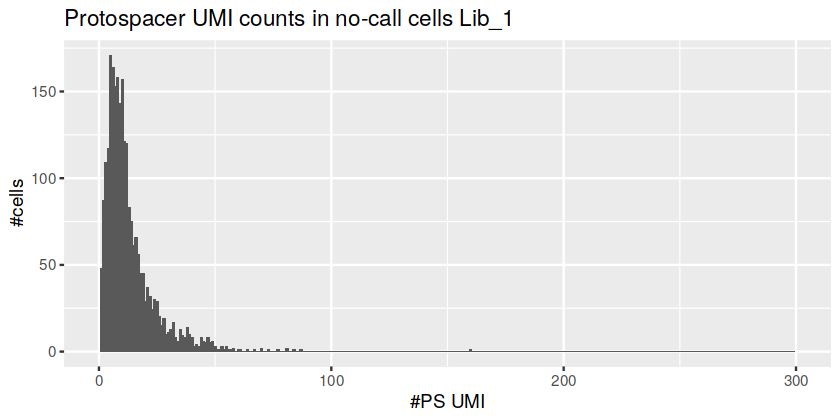

In [33]:
options(repr.plot.width=7, repr.plot.height=3.5)
title = paste("Protospacer UMI counts in no-call cells", my_library)

ggplot(df_sums, aes(x = sgRNA_count)) +
    geom_histogram(binwidth=1) +
    labs(x = "#PS UMIs") +
    labs(y = "#cells") + 
    labs(title = title) +
    xlim(0,300)

In [34]:
nrow(df_sums)

[1] 2462

#### Inspect the total guide counts again

In [35]:
df_sums = data.frame(rowSums(seurat_subset[['sgRNA']]@counts))
colnames(df_sums) = "total_count"
df_sums$protospacer = rownames(df_sums)

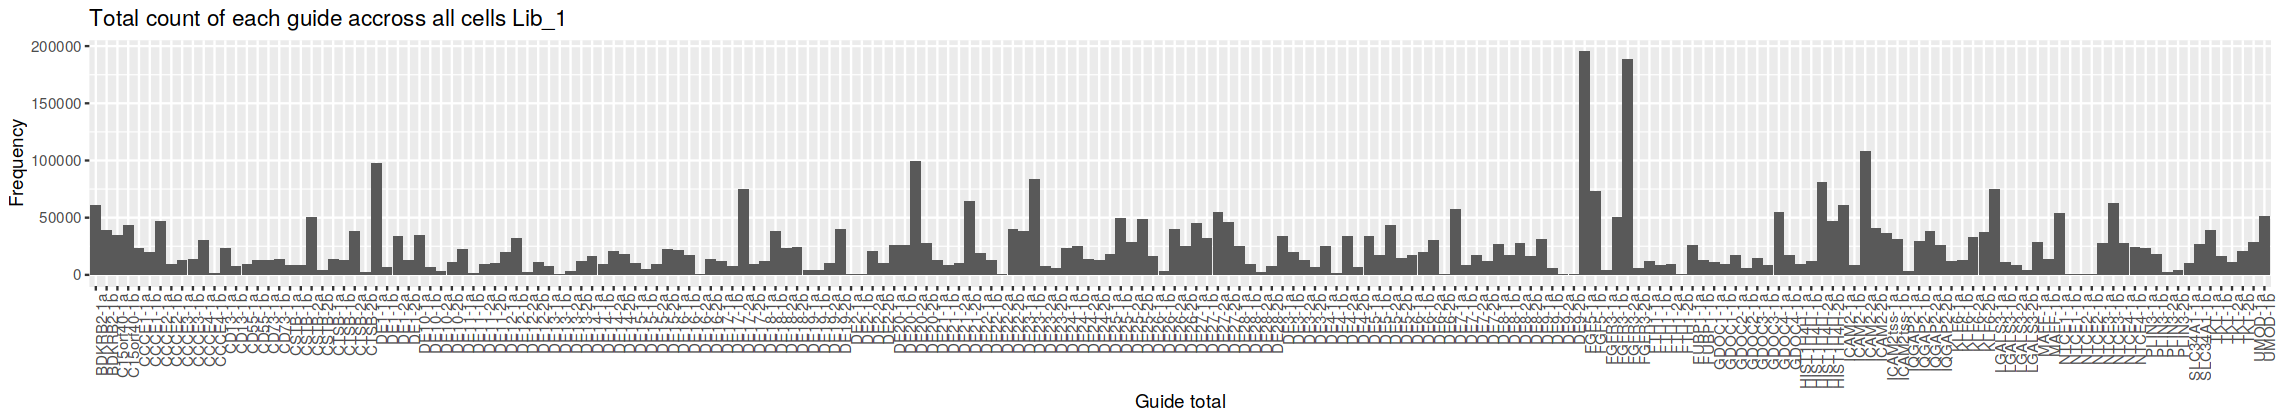

In [36]:
options(repr.plot.width=19, repr.plot.height=3.5)
df_sums = df_sums %>% arrange(total_count, desc=T)

title = paste("Total count of each guide accross all cells", my_library)

ggplot(df_sums, aes(y = total_count, x = protospacer)) +
    geom_bar(stat='identity') +
    labs(x = "Guide total") +
    labs(y = "Frequency") + 
    labs(title = title) +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) 

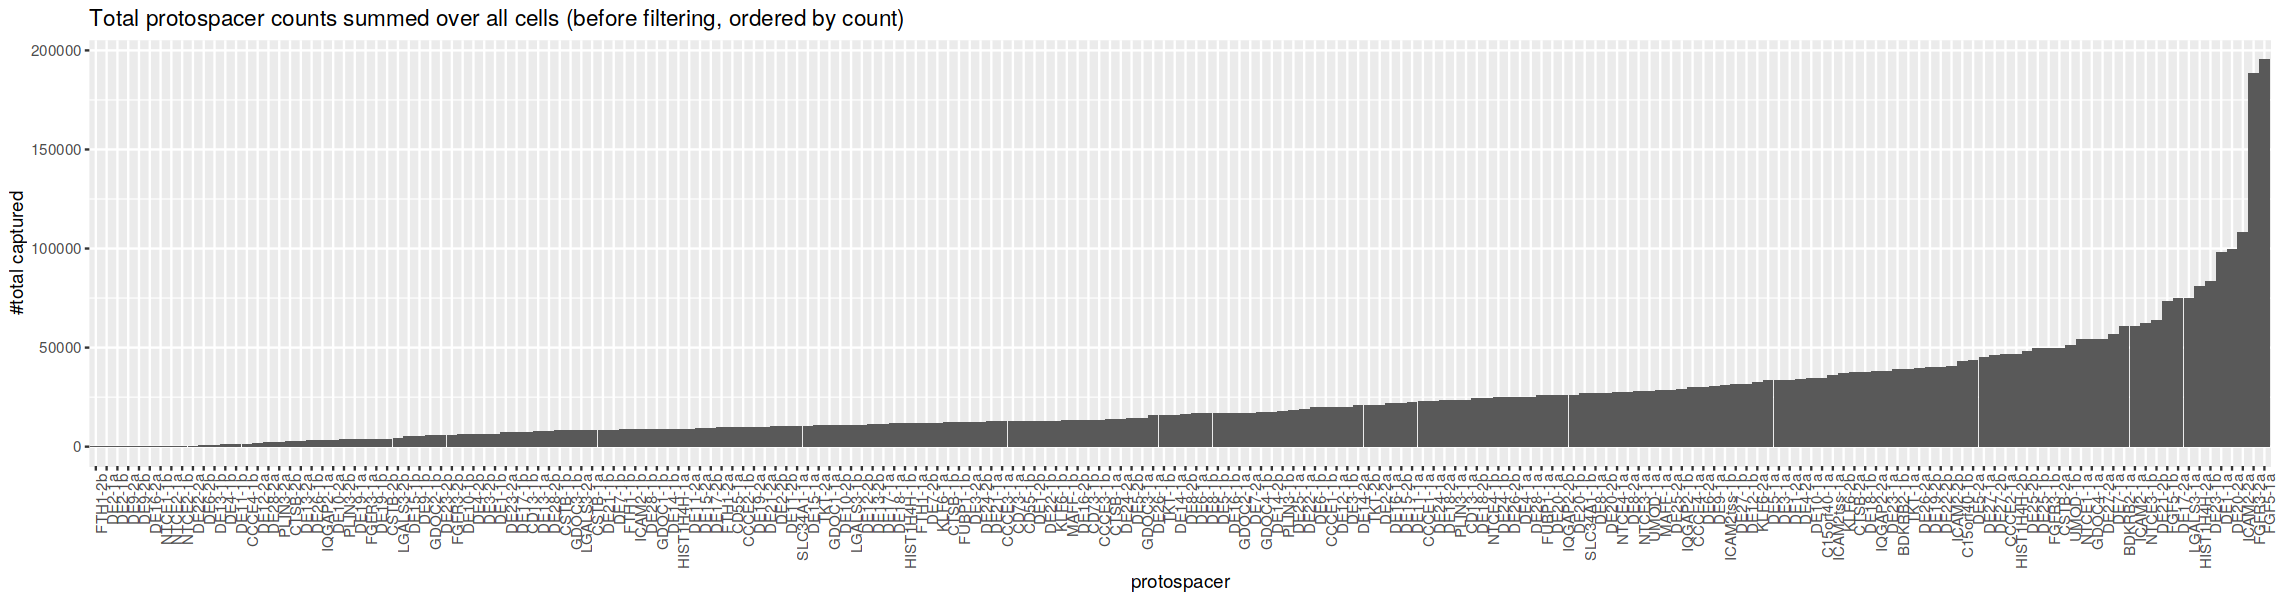

In [37]:
df_sums$protospacer <- factor(df_sums$protospacer, levels = df_sums$protospacer)

options(repr.plot.width=19, repr.plot.height=5)
ggplot(df_sums, aes(x=protospacer, y=total_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by count)", x = "protospacer") +
    labs(y = "#total captured") 

In [38]:
head(df_sums %>% arrange(total_count), 15)

,total_count,protospacer
,<dbl>,<fct>
FTH1-2b,0,FTH1-2b
DE2-1a,0,DE2-1a
DE2-1b,0,DE2-1b
DE9-2a,0,DE9-2a
DE9-2b,0,DE9-2b
DE16-2a,0,DE16-2a
NTCE1-1b,0,NTCE1-1b
NTCE2-1a,0,NTCE2-1a
NTCE2-1b,0,NTCE2-1b
